In [1]:
import jax
jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True) 

import jaxgym.components as comp
from jaxgym.ray import Ray
from jaxgym.run import run_to_end, run_to_end_with_history
from jax import config
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt
from jaxgym.plot import plot_model
from jaxgym.utils import custom_jacobian_matrix
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="0.00001"
%matplotlib widget



/home/dl277493/JaxTemGym/src/jaxgym/ode.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange, tqdm


0.009876543209876543


<Axes: title={'center': 'Ray Paths Through Optical System'}, xlabel='X', ylabel='Z'>

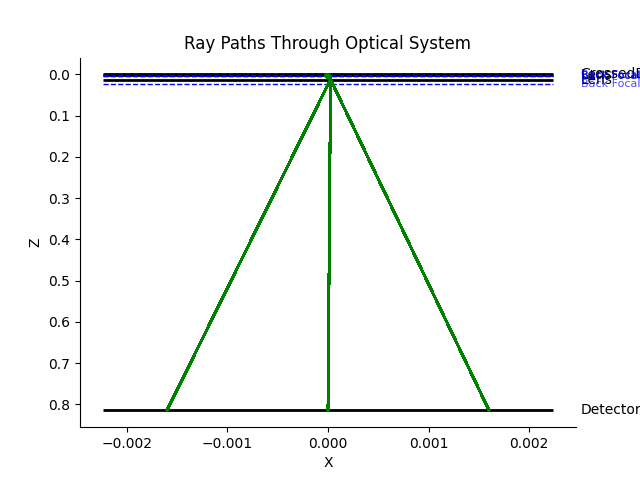

In [2]:
from jax import vmap
from dataclasses import replace

detector_distance = 0.8
z_obj = 2.5e-3
f_obj = 2e-3

z1 = -1e-2
z2 = detector_distance

f_eff = (1/z2 - 1/z1)**-1
M_eff = z2/z1
print(f_eff)
DiffractionGrating = comp.CrossedDiffractionGrating(z=0.0, spacing = 1e-8, max_order = 1)
ObjLens = comp.Lens(z=z_obj, focal_length=f_obj)
CombinedLens = comp.Lens(z=z_obj + f_obj + jnp.abs(z1), focal_length=f_eff)
Detector = comp.Detector(z=CombinedLens.z + detector_distance, det_pixel_size=(1e-4, 1e-4), det_shape=(256, 256))


model = [DiffractionGrating, ObjLens, CombinedLens, Detector]

x = jnp.linspace(-0.5e-5, -0.5e-5, 10)
x = jnp.concatenate((x, jnp.linspace(-0.5e-5, -0.5e-5, 10)))
x = jnp.concatenate((x, jnp.linspace(-0.5e-5, -0.5e-5, 10)))
y = jnp.zeros_like(x)
xs, ys = jnp.meshgrid(x, y)
xs = xs.flatten()
ys = ys.flatten()

zs = jnp.ones_like(xs) * DiffractionGrating.z
dx = jnp.zeros_like(xs)
dy = jnp.zeros_like(xs)
pathlengths = jnp.zeros_like(xs)
wavelengths = jnp.ones_like(xs) * 1e-10
ones = jnp.ones_like(xs)

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, xs.shape[0])

rays = Ray(x=xs, y=ys, z=zs, dx=dx, dy=dy, pathlength=pathlengths, wavelength=wavelengths, _one=ones, keys=keys)
run_to_end_vmap = vmap(lambda ray, k: run_to_end_with_history(replace(ray, keys=k), model), in_axes=(0,0))
out_rays = run_to_end_vmap(rays, keys)

plot_model(model, out_rays)


144 144


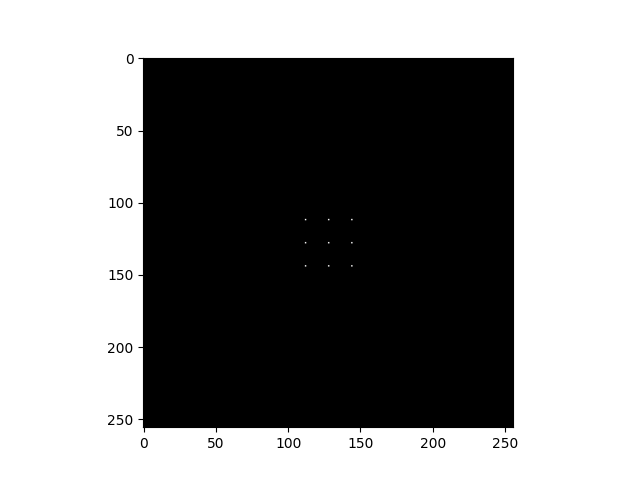

In [3]:
det_pixels_y, det_pixels_x = Detector.metres_to_pixels([out_rays[-1].x, out_rays[-1].y])

det_image = np.zeros(Detector.det_shape)

# only keep rays that land inside the detector array
h, w = Detector.det_shape
mask = (det_pixels_y >= 0) & (det_pixels_y < h) & (det_pixels_x >= 0) & (det_pixels_x < w)
valid_y = det_pixels_y[mask]
valid_x = det_pixels_x[mask]
det_image[valid_y, valid_x] += 1.0

print(jnp.max(valid_x), jnp.max(valid_y))
plt.figure()
plt.imshow(det_image, cmap='gray')

In [4]:
#ABCD Matrix
ray = Ray(x=jnp.array(0.0), 
          y=jnp.array(0.0), 
          dx=jnp.array(0.0), 
          dy=jnp.array(0.0), 
          wavelength=jnp.array(1e-10), 
          z=jnp.array(0.0), 
          pathlength=jnp.array(0.0), 
          _one=jnp.array(1.0),
          keys=jax.random.PRNGKey(0))

#call jax.jacobian on run to end for the ABCD matrix
out_ray = run_to_end(ray, model)

def flat_outputs(x, y, dx, dy):
    r = Ray(x=x, 
            y=y, 
            dx=dx, 
            dy=dy, 
            wavelength=jnp.array(1e-10), 
            z=jnp.array(0.0), 
            pathlength=jnp.array(0.0), 
            _one=jnp.array(1.0), 
            keys=jax.random.PRNGKey(0))
    
    o = run_to_end(r, model)
    return jnp.stack([o.x, o.y, o.dx, o.dy])

jacobian = jax.jacobian(flat_outputs, argnums=[0, 1, 2, 3])
ray_jac = jacobian(ray.x, ray.y, ray.dx, ray.dy)

jac = jnp.array(ray_jac).T
print(jac)
L = (M_eff * f_obj)

print("L", L)
print(-1*ray_jac[0][2])


[[-4.26325641e-14  0.00000000e+00 -1.60024003e-01  0.00000000e+00]
 [ 0.00000000e+00 -4.26325641e-14  0.00000000e+00 -1.60008001e-01]
 [ 6.25000000e+00  0.00000000e+00 -1.99404910e-01  0.00000000e+00]
 [ 0.00000000e+00  6.25000000e+00  0.00000000e+00 -1.99384969e-01]]
L -0.16
-6.250000000000043
